In [22]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from libpysal import weights
import networkx as nx

import os
print("Current working directory:", os.getcwd())

Current working directory: c:\Users\laszlovreedenb\OneDrive - Delft University of Technology\Documents\code\flee\data_assimilation\test


In [58]:
# Load the shapefile
# shapefile_path = '../../disaster_sources/mozambique/moz_adm_shp/moz_admbnda_adm3_ine_20190607.shp'
# gdf = gpd.read_file(shapefile_path)
# zambezia_gdf = gdf[gdf['ADM1_PCODE'] == 'MZ11'].reset_index(drop=True)
# zambezia_gdf[:10]

shapefile_path = '../../disaster_sources/mozambique/moz_admbnda_adm3_ine__km2/moz_admbnda_adm3_ine_20190910_km2.shp'
gdf = gpd.read_file(shapefile_path)
zambezia_gdf = gdf[gdf['admin1Pcod'] == 'MZ11'].reset_index(drop=True)
zambezia_gdf[:10]


,OBJECTID,admin3Name,admin3Pcod,admin3RefN,admin3AltN,admin3Al_1,admin2Name,admin2Pcod,admin1Name,admin1Pcod,admin0Name,admin0Na_1,admin0Pcod,date,validOn,validTo,Shape_Leng,Shape_Area,km2,geometry
0,3,Alto Ligonha,MZ110501,None,None,None,Gile,MZ1105,Zambezia,MZ11,Mozambique,Moçambique,MZ,2019-04-02,2019-06-07,NaT,3.980541,0.328787,3900.627066,"POLYGON ((1331254.796 -1798579.831, 1331380.15..."
1,4,Alto Molocue,MZ110101,None,None,None,Alto Molocue,MZ1101,Zambezia,MZ11,Mozambique,Moçambique,MZ,2019-04-02,2019-06-07,NaT,3.154156,0.315408,3738.844663,"POLYGON ((1326383.693 -1829361.041, 1326397.10..."
2,11,Bajone,MZ111501,None,None,None,Mocubela,MZ1115,Zambezia,MZ11,Mozambique,Moçambique,MZ,2019-04-02,2019-06-07,NaT,2.336629,0.114528,1348.087145,"POLYGON ((1336544.17 -2005771.063, 1342400.622..."
3,24,Campo,MZ111701,None,None,None,Mopeia,MZ1117,Zambezia,MZ11,Mozambique,Moçambique,MZ,2019-04-02,2019-06-07,NaT,3.306913,0.312639,3668.170692,"POLYGON ((1132864.829 -2058199.197, 1138132.39..."
4,49,Chinde,MZ110201,None,None,None,Chinde,MZ1102,Zambezia,MZ11,Mozambique,Moçambique,MZ,2019-04-02,2019-06-07,NaT,2.417263,0.087756,1024.632083,"MULTIPOLYGON (((1163575.637 -2207006.697, 1163..."
5,58,Chire,MZ111801,None,None,None,Morrumbala,MZ1118,Zambezia,MZ11,Mozambique,Moçambique,MZ,2019-04-02,2019-06-07,NaT,3.404664,0.282486,3333.964333,"POLYGON ((1061754.6 -1926256.036, 1061853.178 ..."
6,80,Cidade De Quelimane,MZ110301,None,None,None,Cidade De Quelimane,MZ1103,Zambezia,MZ11,Mozambique,Moçambique,MZ,2019-04-02,2019-06-07,NaT,0.586949,0.010371,121.662196,"POLYGON ((1217645.119 -2103120.341, 1217617.14..."
7,91,Derre,MZ110401,None,None,None,Derre,MZ1104,Zambezia,MZ11,Mozambique,Moçambique,MZ,2019-04-02,2019-06-07,NaT,3.333202,0.402970,4746.788748,"POLYGON ((1131116.84 -1957800.099, 1131198.356..."
8,106,Gile,MZ110502,None,None,None,Gile,MZ1105,Zambezia,MZ11,Mozambique,Moçambique,MZ,2019-04-02,2019-06-07,NaT,3.591334,0.428881,5076.389744,"POLYGON ((1399437.221 -1908270.157, 1399387.85..."
9,109,Gonhane,MZ110801,None,None,None,Inhassunge,MZ1108,Zambezia,MZ11,Mozambique,Moçambique,MZ,2019-04-02,2019-06-07,NaT,0.947010,0.021268,249.111677,"MULTIPOLYGON (((1212882.342 -2138440.375, 1212..."


C:\Users\laszlovreedenb\AppData\Local\Temp\ipykernel_22152\1658522710.py:9: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  queen = weights.Queen.from_dataframe(zambezia_gdf)


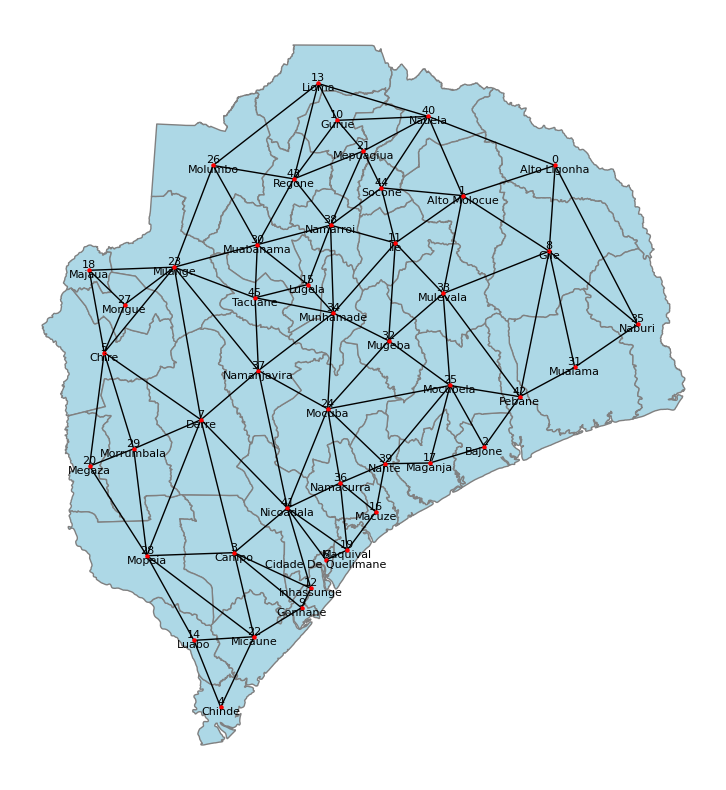

In [59]:
# extract the centroids for connecting the regions, which is
# the average of the coordinates that define the polygon's boundary
# Note: When actually using this, the centroid will not be the place where moest people live and move from.
centroids = np.column_stack((zambezia_gdf.centroid.x, zambezia_gdf.centroid.y))

# construct the "Queen" adjacency graph. In geographical applications,
# the "Queen" adjacency graph considers two polygons as connected if
# they share a single point on their boundary. 
queen = weights.Queen.from_dataframe(zambezia_gdf)
# print(queen)

# Then, we can convert the graph to networkx object using the
# .to_networkx() method.
graph = queen.to_networkx()
# print(graph)

# # To plot with networkx, we need to merge the nodes back to
# # their positions in order to plot in networkx
positions = dict(zip(graph.nodes, centroids))
# print(positions)

# Add edge lengths as attributes (distance between centroids)
for u, v in graph.edges():
    x1, y1 = positions[u]
    x2, y2 = positions[v]
    length = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    graph[u][v]['length'] = length


# # plot with a nice basemap
fig, ax = plt.subplots(figsize=(10, 10))
zambezia_gdf.plot(linewidth=1, edgecolor="grey", facecolor="lightblue", ax=ax)
# Add labels at centroids
for idx, row in zambezia_gdf.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, zambezia_gdf.iloc[idx]['admin3Name'], fontsize=8, ha='center', va='top', color='black')


nx.draw(graph, positions, ax=ax, node_size=5, node_color="r")
nx.draw_networkx_labels(graph, positions, ax=ax, font_size=8, verticalalignment='bottom')
plt.show()

In [60]:
# Reproject to lon/lat and get centroids
zambezia_gdf_lonlat = zambezia_gdf.to_crs(epsg=4326)
centroids_lonlat = np.column_stack((zambezia_gdf_lonlat.centroid.x, zambezia_gdf_lonlat.centroid.y))

# Add as new columns
zambezia_gdf['centroid_lon'] = centroids_lonlat[:, 0]
zambezia_gdf['centroid_lat'] = centroids_lonlat[:, 1]
zambezia_gdf[:10]

C:\Users\laszlovreedenb\AppData\Local\Temp\ipykernel_22152\1117705881.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_lonlat = np.column_stack((zambezia_gdf_lonlat.centroid.x, zambezia_gdf_lonlat.centroid.y))


,OBJECTID,admin3Name,admin3Pcod,admin3RefN,admin3AltN,admin3Al_1,admin2Name,admin2Pcod,admin1Name,admin1Pcod,...,admin0Pcod,date,validOn,validTo,Shape_Leng,Shape_Area,km2,geometry,centroid_lon,centroid_lat
0,3,Alto Ligonha,MZ110501,None,None,None,Gile,MZ1105,Zambezia,MZ11,...,MZ,2019-04-02,2019-06-07,NaT,3.980541,0.328787,3900.627066,"POLYGON ((1331254.796 -1798579.831, 1331380.15...",38.325947,-15.659667
1,4,Alto Molocue,MZ110101,None,None,None,Alto Molocue,MZ1101,Zambezia,MZ11,...,MZ,2019-04-02,2019-06-07,NaT,3.154156,0.315408,3738.844663,"POLYGON ((1326383.693 -1829361.041, 1326397.10...",37.752281,-15.829796
2,11,Bajone,MZ111501,None,None,None,Mocubela,MZ1115,Zambezia,MZ11,...,MZ,2019-04-02,2019-06-07,NaT,2.336629,0.114528,1348.087145,"POLYGON ((1336544.17 -2005771.063, 1342400.622...",37.895245,-17.225211
3,24,Campo,MZ111701,None,None,None,Mopeia,MZ1117,Zambezia,MZ11,...,MZ,2019-04-02,2019-06-07,NaT,3.306913,0.312639,3668.170692,"POLYGON ((1132864.829 -2058199.197, 1138132.39...",36.344782,-17.823950
4,49,Chinde,MZ110201,None,None,None,Chinde,MZ1102,Zambezia,MZ11,...,MZ,2019-04-02,2019-06-07,NaT,2.417263,0.087756,1024.632083,"MULTIPOLYGON (((1163575.637 -2207006.697, 1163...",36.265479,-18.690600
5,58,Chire,MZ111801,None,None,None,Morrumbala,MZ1118,Zambezia,MZ11,...,MZ,2019-04-02,2019-06-07,NaT,3.404664,0.282486,3333.964333,"POLYGON ((1061754.6 -1926256.036, 1061853.178 ...",35.531450,-16.711103
6,80,Cidade De Quelimane,MZ110301,None,None,None,Cidade De Quelimane,MZ1103,Zambezia,MZ11,...,MZ,2019-04-02,2019-06-07,NaT,0.586949,0.010371,121.662196,"POLYGON ((1217645.119 -2103120.341, 1217617.14...",36.915137,-17.861756
7,91,Derre,MZ110401,None,None,None,Derre,MZ1104,Zambezia,MZ11,...,MZ,2019-04-02,2019-06-07,NaT,3.333202,0.402970,4746.788748,"POLYGON ((1131116.84 -1957800.099, 1131198.356...",36.134364,-17.082770
8,106,Gile,MZ110502,None,None,None,Gile,MZ1105,Zambezia,MZ11,...,MZ,2019-04-02,2019-06-07,NaT,3.591334,0.428881,5076.389744,"POLYGON ((1399437.221 -1908270.157, 1399387.85...",38.291383,-16.135612
9,109,Gonhane,MZ110801,None,None,None,Inhassunge,MZ1108,Zambezia,MZ11,...,MZ,2019-04-02,2019-06-07,NaT,0.947010,0.021268,249.111677,"MULTIPOLYGON (((1212882.342 -2138440.375, 1212...",36.764763,-18.130413


In [91]:
pop_df_all = pd.read_excel('../../disaster_sources/mozambique/Mozambique_pop_us_census.xlsx')
pop_df = pop_df_all[pop_df_all['CODE'].str.startswith('MZ004')]
pop_df = pop_df[pop_df['ADM_LEVEL']==3]
pop_df = pop_df[pop_df['YR']==2023].reset_index(drop=True)
pop_df

,CODE,BASENAME,ADM_LEVEL,YR,GENC,FIPS,SEXRATIO,DEPND,DEPND0_14,DEPND65_,...,FPOP55_59,FPOP60_64,FPOP65_69,FPOP70_74,FPOP75_79,FPOP80_84,FPOP85_89,FPOP90_94,FPOP95_99,FPOP100_
0,MZ004001001,Quelimane,3,2023,MZ,MZ,0.99,69.5,66.3,3.2,...,2321,1645,965,866,505,312,122,30,3,2
1,MZ004001002,Maquival,3,2023,MZ,MZ,0.95,91.5,85.0,6.5,...,1073,943,605,549,261,161,64,16,2,1
2,MZ004002001,Alto Molócuè Sede,3,2023,MZ,MZ,0.98,105.1,100.7,4.3,...,2571,1705,1179,995,591,296,115,27,3,0
3,MZ004002002,Nauela,3,2023,MZ,MZ,0.96,106.3,101.9,4.5,...,845,619,372,351,180,87,34,8,1,0
4,MZ004003001,Chinde Sede,3,2023,MZ,MZ,0.98,101.4,95.1,6.2,...,590,462,354,246,174,90,36,8,1,0
5,MZ004003002,Micaune,3,2023,MZ,MZ,0.98,96.1,90.7,5.3,...,349,274,160,99,73,32,12,3,0,0
6,MZ004004001,Gilé,3,2023,MZ,MZ,1.00,101.3,97.0,4.3,...,1260,802,649,428,263,119,46,11,1,0
7,MZ004004002,Alto Ligonha,3,2023,MZ,MZ,1.02,109.6,104.8,4.7,...,873,499,386,284,196,61,24,6,1,0
8,MZ004005001,Cidade de Guruè,3,2023,MZ,MZ,1.00,93.2,89.5,3.7,...,1770,1189,795,577,312,160,62,15,2,0
9,MZ004005002,Lioma,3,2023,MZ,MZ,0.99,101.6,98.1,3.5,...,1441,882,547,427,247,142,55,13,1,0


In [92]:
# Create dictionary to use the UN name for the regions
name_pop_dict = {'Alto Molócuè Sede':'Alto Molocue',
                 'Chinde Sede':'Chinde',
                 'Gilé':'Gile',
                 'Cidade de Guruè':'Gurue',
                 'Cidade de Mocuba':'Mocuba',
                 'Lugela Sede': 'Lugela',
                 'Mucupia':'Inhassunge',
                 'Macuse':'Macuze',
                 'Maganja da Costa':'Maganja',
                 'Milange Sede':'Milange',
                 'Mopeia Sede': 'Mopeia',
                 'Morrumbala Sede': 'Morrumbala',
                 'Namacurra Sede': 'Namacurra',
                 'Pebane Sede': 'Pebane',
                 'Quelimane':'Cidade De Quelimane',
                 'Mulela':'Mualama',
                 }


pop_df['BASENAME']= pop_df['BASENAME'].replace(name_pop_dict)

# Derre is not split in the UN data, but is in the Census data, drop Machindo and Guerissa
# Luabo is not split in the UN data, but is in the Census data, drop Samora Machel and Chimbadzo 
# Mulevala is not in the UN data, but is in the Census data, drop M Bauane and Chiraco
pop_df_adm2 = pop_df_all[pop_df_all['BASENAME'].isin(['Derre', 'Luabo', 'Mulevala', 'Molumbo', 'Nicoadala'])]
pop_df_adm2 = pop_df_adm2[pop_df_adm2['YR']==2023].reset_index(drop=True)

# Add Malei to Namacurra, as it is not in the UN data

# Drop specific BASENAME values from pop_df
to_drop = ['Machindo', 
           'Guerissa', 
           'Samora Machel', 
           'Chimbadzo', 
           'M Bauane', 
           'Chiraco', 
           'Molumbo Sede', 
           'Corromana',
           'Nicoadala Sede',
           'Munhonha', 
           'Namacata']
pop_df = pop_df[~pop_df['BASENAME'].isin(to_drop)].reset_index(drop=True)
pop_df = pd.concat([pop_df, pop_df_adm2], ignore_index=True)

In [94]:
ratio_cols = ['SEXRATIO', 'DEPND', 'DEPND0_14', 'DEPND65_',]  
pop_cols = ['POP', 'POP0_4', 'POP5_9', 'POP10_14',
       'POP15_19', 'POP20_24', 'POP25_29', 'POP30_34', 'POP35_39', 'POP40_44',
       'POP45_49', 'POP50_54', 'POP55_59', 'POP60_64', 'POP65_69', 'POP70_74',
       'POP75_79', 'POP80_84', 'POP85_89', 'POP90_94', 'POP95_99', 'POP100_',
       'MPOP', 'MPOP0_4', 'MPOP5_9', 'MPOP10_14', 'MPOP15_19', 'MPOP20_24',
       'MPOP25_29', 'MPOP30_34', 'MPOP35_39', 'MPOP40_44', 'MPOP45_49',
       'MPOP50_54', 'MPOP55_59', 'MPOP60_64', 'MPOP65_69', 'MPOP70_74',
       'MPOP75_79', 'MPOP80_84', 'MPOP85_89', 'MPOP90_94', 'MPOP95_99',
       'MPOP100_', 'FPOP', 'FPOP0_4', 'FPOP5_9', 'FPOP10_14', 'FPOP15_19',
       'FPOP20_24', 'FPOP25_29', 'FPOP30_34', 'FPOP35_39', 'FPOP40_44',
       'FPOP45_49', 'FPOP50_54', 'FPOP55_59', 'FPOP60_64', 'FPOP65_69',
       'FPOP70_74', 'FPOP75_79', 'FPOP80_84', 'FPOP85_89', 'FPOP90_94',
       'FPOP95_99', 'FPOP100_']
pop_df = pop_df.copy()
pop_df_namacurra = pop_df[pop_df['BASENAME'].isin(['Namacurra','Malei'])]

# Calculate population-weighted averages for ratio columns
weights = pop_df_namacurra['POP']
weighted_avg_ratios = {}

for col in ratio_cols:
    weighted_avg_ratios[col] = np.average(pop_df_namacurra[col], weights=weights)

sum_pops = pop_df_namacurra[pop_cols].sum()

# Create a new row as a dictionary
new_row = {}
for col in ratio_cols:
    new_row[col] = weighted_avg_ratios[col]
for col in pop_cols:
    new_row[col] = sum_pops[col]

for col in ratio_cols + pop_cols:
    pop_df.loc[pop_df['BASENAME'] == 'Namacurra', col] = new_row[col]

# Round SEXRATIO to 2 decimals
pop_df['SEXRATIO'] = pop_df['SEXRATIO'].round(2)

# Round DEPND columns to 1 decimal
pop_df['DEPND'] = pop_df['DEPND'].round(1)
pop_df['DEPND0_14'] = pop_df['DEPND0_14'].round(1)
pop_df['DEPND65_'] = pop_df['DEPND65_'].round(1)


pop_df = pop_df[pop_df['BASENAME'] != 'Malei'].reset_index(drop=True)

In [95]:
# Get sets of names
gdf_names = set(zambezia_gdf['admin3Name'])
pop_names = set(pop_df['BASENAME'])

# Find matches and remainders
matches = gdf_names & pop_names
gdf_only = gdf_names - pop_names
pop_only = pop_names - gdf_names

# Convert to sorted lists for easier viewing
matches = sorted(matches)
gdf_only = sorted(gdf_only)
pop_only = sorted(pop_only)

print("Matches:", matches)
print("In zambezia_gdf only:", gdf_only)
print("In pop_df only:", pop_only)

Matches: ['Alto Ligonha', 'Alto Molocue', 'Bajone', 'Campo', 'Chinde', 'Chire', 'Cidade De Quelimane', 'Derre', 'Gile', 'Gonhane', 'Gurue', 'Ile', 'Inhassunge', 'Lioma', 'Luabo', 'Lugela', 'Macuze', 'Maganja', 'Majaua', 'Maquival', 'Megaza', 'Mepuagiua', 'Micaune', 'Milange', 'Mocuba', 'Mocubela', 'Molumbo', 'Mongue', 'Mopeia', 'Morrumbala', 'Muabanama', 'Mualama', 'Mugeba', 'Mulevala', 'Munhamade', 'Naburi', 'Namacurra', 'Namanjavira', 'Namarroi', 'Nante', 'Nauela', 'Nicoadala', 'Pebane', 'Regone', 'Socone', 'Tacuane']
In zambezia_gdf only: []
In pop_df only: []


In [108]:
col_names = ['admin3Name', 'admin2Name', 'admin1Name', 'centroid_lat', 'centroid_lon',]
locations_gdf = zambezia_gdf[col_names]
locations_gdf['location_type'] = 'flood_zone'
locations_gdf['conflict_date'] = 0

locations_gdf = locations_gdf.merge(
    pop_df[['BASENAME', 'POP']],
    left_on='admin3Name',
    right_on='BASENAME',
    how='left'
)
locations_gdf = locations_gdf.drop(columns=['BASENAME'])  # Optional: remove BASENAME column after merge
locations_gdf = locations_gdf.rename(columns={
    'admin3Name': '#name',
    'admin2Name': 'region',
    'admin1Name': 'country',
    'POP': 'population',
    'centroid_lat': 'lat',
    'centroid_lon': 'lon'
})
locations_gdf.to_csv('../../disaster_input/mozambique/locations.csv', index=False)

C:\Users\laszlovreedenb\AppData\Local\Temp\ipykernel_22152\1884941466.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locations_gdf['location_type'] = 'flood_zone'
C:\Users\laszlovreedenb\AppData\Local\Temp\ipykernel_22152\1884941466.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locations_gdf['conflict_date'] = 0


In [111]:
# Create routes input
# Create a mapping from node index to admin3Name
index_to_name = zambezia_gdf['admin3Name'].to_dict()

# Build the list of edges with names and lengths
edges_with_names = []
for u, v, data in graph.edges(data=True):
    name_u = index_to_name[u]
    name_v = index_to_name[v]
    length = round(data['length'])
    edges_with_names.append((name_u, name_v, length))

# Create a DataFrame from edges_with_names
routes_df = pd.DataFrame(edges_with_names, columns=['#name1', 'name2', 'distance'])
routes_df['forced_redirection'] = 0
routes_df.to_csv('../../disaster_input/mozambique/routes.csv', index=False)
routes_df.head()

,#name1,name2,distance,forced_redirection
0,Alto Ligonha,Alto Molocue,62168,0
1,Alto Ligonha,Gile,54944,0
2,Alto Ligonha,Naburi,114327,0
3,Alto Ligonha,Nauela,86925,0
4,Alto Molocue,Gile,65699,0
